# Mortgage PD scorecard

## Import libraries

In [1]:
%reset

Nothing done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning, BinningProcess
from optbinning import BinningProcess    
from scipy.stats import spearmanr
from itertools import combinations

(CVXPY) Jan 13 02:51:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 13 02:51:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


## Step 1: Data Preparation

### Step 1.1: Data Loading

In [3]:
# Load the dataset
file_path = "data/mortgage_sample.csv"  # replace with the actual path or URL
df_raw = pd.read_csv(file_path)

In [4]:
df_raw.head()

id  time  orig_time  first_time  mat_time  balance_time   LTV_time  \
0   1    25         -7          25       113      41303.42  24.498336   
1   1    26         -7          25       113      41061.95  24.483867   
2   1    27         -7          25       113      40804.42  24.626795   
3   1    28         -7          25       113      40483.89  24.735883   
4   1    29         -7          25       113      40367.06  24.925476   

   interest_rate_time  hpi_time  gdp_time  ...  investor_orig_time  \
0                 9.2    226.29  2.899137  ...                   0   
1                 9.2    225.10  2.151365  ...                   0   
2                 9.2    222.39  2.361722  ...                   0   
3                 9.2    219.67  1.229172  ...                   0   
4                 9.2    217.37  1.692969  ...                   0   

   balance_orig_time  FICO_orig_time  LTV_orig_time  Interest_Rate_orig_time  \
0            45000.0             715           69.4                      9.2   
1            45000.0             715           69.4                      9.2   
2            45000.0             715           69.4                      9.2   
3            45000.0             715           69.4                      9.2   
4            45000.0             715           69.4                      9.2   

   hpi_orig_time  default_time  payoff_time  status_time  sample  
0          87.03           0.0          0.0          0.0  public  
1          87.03           0.0          0.0          0.0  public  
2          87.03           0.0          0.0          0.0  public  
3          87.03           0.0          0.0          0.0  public  
4          87.03           0.0          0.0          0.0  public  

[5 rows x 24 columns]

In [5]:
# Display basic information about the dataset
print("\nDataset Information:")
df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       622489 non-null  int64  
 1   time                     622489 non-null  int64  
 2   orig_time                622489 non-null  int64  
 3   first_time               622489 non-null  int64  
 4   mat_time                 622489 non-null  int64  
 5   balance_time             622489 non-null  float64
 6   LTV_time                 622219 non-null  float64
 7   interest_rate_time       622489 non-null  float64
 8   hpi_time                 622489 non-null  float64
 9   gdp_time                 622489 non-null  float64
 10  uer_time                 622489 non-null  float64
 11  REtype_CO_orig_time      622489 non-null  int64  
 12  REtype_PU_orig_time      622489 non-null  int64  
 13  REtype_SF_orig_time      622489 non-n

In [6]:
# Filter out private observations
df_public = df_raw[df_raw['sample'] == 'public']
df_public = df_public.drop(['sample'], axis=1)

#### Filter out ids which end with status_code==0. It means that the loan is still active and we don't know if it will default or not. We can't use this data for training.

In [7]:
filtered_ids = df_public.groupby('id')['status_time'].sum()[lambda x: x > 0].index
df_dev = df_public[df_public['id'].isin(filtered_ids)]

### Step 1.2: Data Exploration

In [8]:
# Display summary statistics
print("\nSummary Statistics:")
df_dev.describe()


Summary Statistics:


id           time      orig_time     first_time  \
count  342027.000000  342027.000000  342027.000000  342027.000000   
mean    24568.108570      31.138162      20.059981      23.445421   
std     13627.324103       9.393406       7.298112       6.014540   
min         1.000000       1.000000     -40.000000       1.000000   
25%     13066.000000      25.000000      17.000000      20.000000   
50%     24292.000000      30.000000      22.000000      24.000000   
75%     36706.000000      37.000000      25.000000      28.000000   
max     49984.000000      60.000000      60.000000      60.000000   

            mat_time  balance_time       LTV_time  interest_rate_time  \
count  342027.000000  3.420270e+05  341971.000000       342027.000000   
mean      136.700500  2.590125e+05      81.217144            7.054329   
std        18.788973  2.216568e+05      23.538631            1.876843   
min        23.000000  0.000000e+00       0.000000            0.000000   
25%       136.000000  1.117557e+05      66.091130            5.875000   
50%       141.000000  1.963633e+05      79.944960            6.875000   
75%       145.000000  3.563412e+05      97.400294            8.000000   
max       229.000000  8.701859e+06     248.432000           37.500000   

            hpi_time       gdp_time  ...  REtype_SF_orig_time  \
count  342027.000000  342027.000000  ...        342027.000000   
mean      189.585114       1.410181  ...             0.612972   
std        29.075380       2.029758  ...             0.487071   
min       107.830000      -4.146711  ...             0.000000   
25%       161.000000       1.104163  ...             0.000000   
50%       188.370000       1.850689  ...             1.000000   
75%       217.370000       2.899137  ...             1.000000   
max       226.290000       5.132464  ...             1.000000   

       investor_orig_time  balance_orig_time  FICO_orig_time  LTV_orig_time  \
count       342027.000000       3.420270e+05   342027.000000  342027.000000   
mean             0.127154       2.670999e+05      672.249667      79.143273   
std              0.333146       2.275251e+05       71.950202       9.914621   
min              0.000000       0.000000e+00      400.000000      50.100000   
25%              0.000000       1.160000e+05      624.000000      75.000000   
50%              0.000000       2.000000e+05      675.000000      80.000000   
75%              0.000000       3.680000e+05      728.000000      80.000000   
max              1.000000       8.000000e+06      840.000000     178.600000   

       Interest_Rate_orig_time  hpi_orig_time   default_time    payoff_time  \
count            342027.000000  342027.000000  342027.000000  342027.000000   
mean                  5.583407     196.079591       0.039833       0.070009   
std                   3.106879      34.496150       0.195567       0.255163   
min                   0.000000      75.710000       0.000000       0.000000   
25%                   4.875000     179.450000       0.000000       0.000000   
50%                   6.300000     212.730000       0.000000       0.000000   
75%                   7.500000     222.390000       0.000000       0.000000   
max                  18.000000     226.290000       1.000000       1.000000   

         status_time  
count  342027.000000  
mean        0.179851  
std         0.536212  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         2.000000  

[8 rows x 23 columns]

#### New features

In [9]:
# balance orig time cannot be 0
df_dev = df_dev[df_dev['balance_orig_time'] > 0]

df_dev['time_until_mat'] = df_dev['mat_time'] - df_dev['time']
df_dev['time_since_orig'] = df_dev['time'] - df_dev['orig_time']
df_dev['balance_paid'] = df_dev['balance_orig_time'] - df_dev['balance_time']
df_dev['balance_paid_perc'] = df_dev['balance_paid'] / df_dev['balance_orig_time']

In [10]:
df_dev[['balance_orig_time', 'time_until_mat', 'time_since_orig','balance_paid', 'balance_paid_perc']].describe()

balance_orig_time  time_until_mat  time_since_orig  balance_paid  \
count       3.419710e+05   341971.000000    341971.000000  3.419710e+05   
mean        2.671436e+05      105.564855        11.076167  8.095067e+03   
std         2.275180e+05       19.284706         9.079739  3.840212e+04   
min         6.246000e+03        1.000000         0.000000 -7.018592e+05   
25%         1.160000e+05      103.000000         5.000000  2.716000e+01   
50%         2.000000e+05      111.000000         8.000000  1.251710e+03   
75%         3.680000e+05      115.000000        15.000000  5.378470e+03   
max         8.000000e+06      198.000000        92.000000  2.251328e+06   

       balance_paid_perc  
count      341971.000000  
mean            0.033554  
std             0.096449  
min            -2.655358  
25%             0.000126  
50%             0.008270  
75%             0.030542  
max             1.000000

In [11]:
# Check for missing values
print("\nMissing Values:")
df_dev.isnull().sum()


Missing Values:


id                         0
time                       0
orig_time                  0
first_time                 0
mat_time                   0
balance_time               0
LTV_time                   0
interest_rate_time         0
hpi_time                   0
gdp_time                   0
uer_time                   0
REtype_CO_orig_time        0
REtype_PU_orig_time        0
REtype_SF_orig_time        0
investor_orig_time         0
balance_orig_time          0
FICO_orig_time             0
LTV_orig_time              0
Interest_Rate_orig_time    0
hpi_orig_time              0
default_time               0
payoff_time                0
status_time                0
time_until_mat             0
time_since_orig            0
balance_paid               0
balance_paid_perc          0
dtype: int64

In [12]:
# Count the number of rows with missing values
null_rows = df_dev.isnull().any(axis=0)
print("\nNumber of rows with missing values:", null_rows.sum())


Number of rows with missing values: 0


In [13]:
# First, select numerical variables only
num_vars = df_dev.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

print("\nDescriptive statistics:")
df_dev[num_vars].describe()


Descriptive statistics:


time      orig_time     first_time       mat_time  \
count  341971.000000  341971.000000  341971.000000  341971.000000   
mean       31.138421      20.062254      23.445166     136.703276   
std         9.393946       7.296521       6.015000      18.787551   
min         1.000000     -40.000000       1.000000      23.000000   
25%        25.000000      17.000000      20.000000     136.000000   
50%        30.000000      22.000000      24.000000     141.000000   
75%        37.000000      25.000000      28.000000     145.000000   
max        60.000000      60.000000      60.000000     229.000000   

       balance_time       LTV_time  interest_rate_time       hpi_time  \
count  3.419710e+05  341971.000000       341971.000000  341971.000000   
mean   2.590485e+05      81.217144            7.053682     189.582296   
std    2.216570e+05      23.538631            1.876209      29.075080   
min    0.000000e+00       0.000000            0.000000     107.830000   
25%    1.117887e+05      66.091130            5.875000     161.000000   
50%    1.963990e+05      79.944960            6.875000     188.370000   
75%    3.563815e+05      97.400294            8.000000     217.370000   
max    8.701859e+06     248.432000           37.500000     226.290000   

            gdp_time       uer_time  ...  LTV_orig_time  \
count  341971.000000  341971.000000  ...  341971.000000   
mean        1.410152       6.083682  ...      79.142818   
std         2.029818       1.875841  ...       9.914030   
min        -4.146711       3.800000  ...      50.100000   
25%         1.104163       4.700000  ...      75.000000   
50%         1.850689       5.000000  ...      80.000000   
75%         2.899137       7.800000  ...      80.000000   
max         5.132464      10.000000  ...     178.600000   

       Interest_Rate_orig_time  hpi_orig_time   default_time    payoff_time  \
count            341971.000000  341971.000000  341971.000000  341971.000000   
mean                  5.583249     196.091687       0.039825       0.070006   
std                   3.106386      34.485983       0.195548       0.255157   
min                   0.000000      75.710000       0.000000       0.000000   
25%                   4.875000     179.450000       0.000000       0.000000   
50%                   6.300000     212.730000       0.000000       0.000000   
75%                   7.500000     222.390000       0.000000       0.000000   
max                  18.000000     226.290000       1.000000       1.000000   

         status_time  time_until_mat  time_since_orig  balance_paid  \
count  341971.000000   341971.000000    341971.000000  3.419710e+05   
mean        0.179837      105.564855        11.076167  8.095067e+03   
std         0.536198       19.284706         9.079739  3.840212e+04   
min         0.000000        1.000000         0.000000 -7.018592e+05   
25%         0.000000      103.000000         5.000000  2.716000e+01   
50%         0.000000      111.000000         8.000000  1.251710e+03   
75%         0.000000      115.000000        15.000000  5.378470e+03   
max         2.000000      198.000000        92.000000  2.251328e+06   

       balance_paid_perc  
count      341971.000000  
mean            0.033554  
std             0.096449  
min            -2.655358  
25%             0.000126  
50%             0.008270  
75%             0.030542  
max             1.000000  

[8 rows x 26 columns]

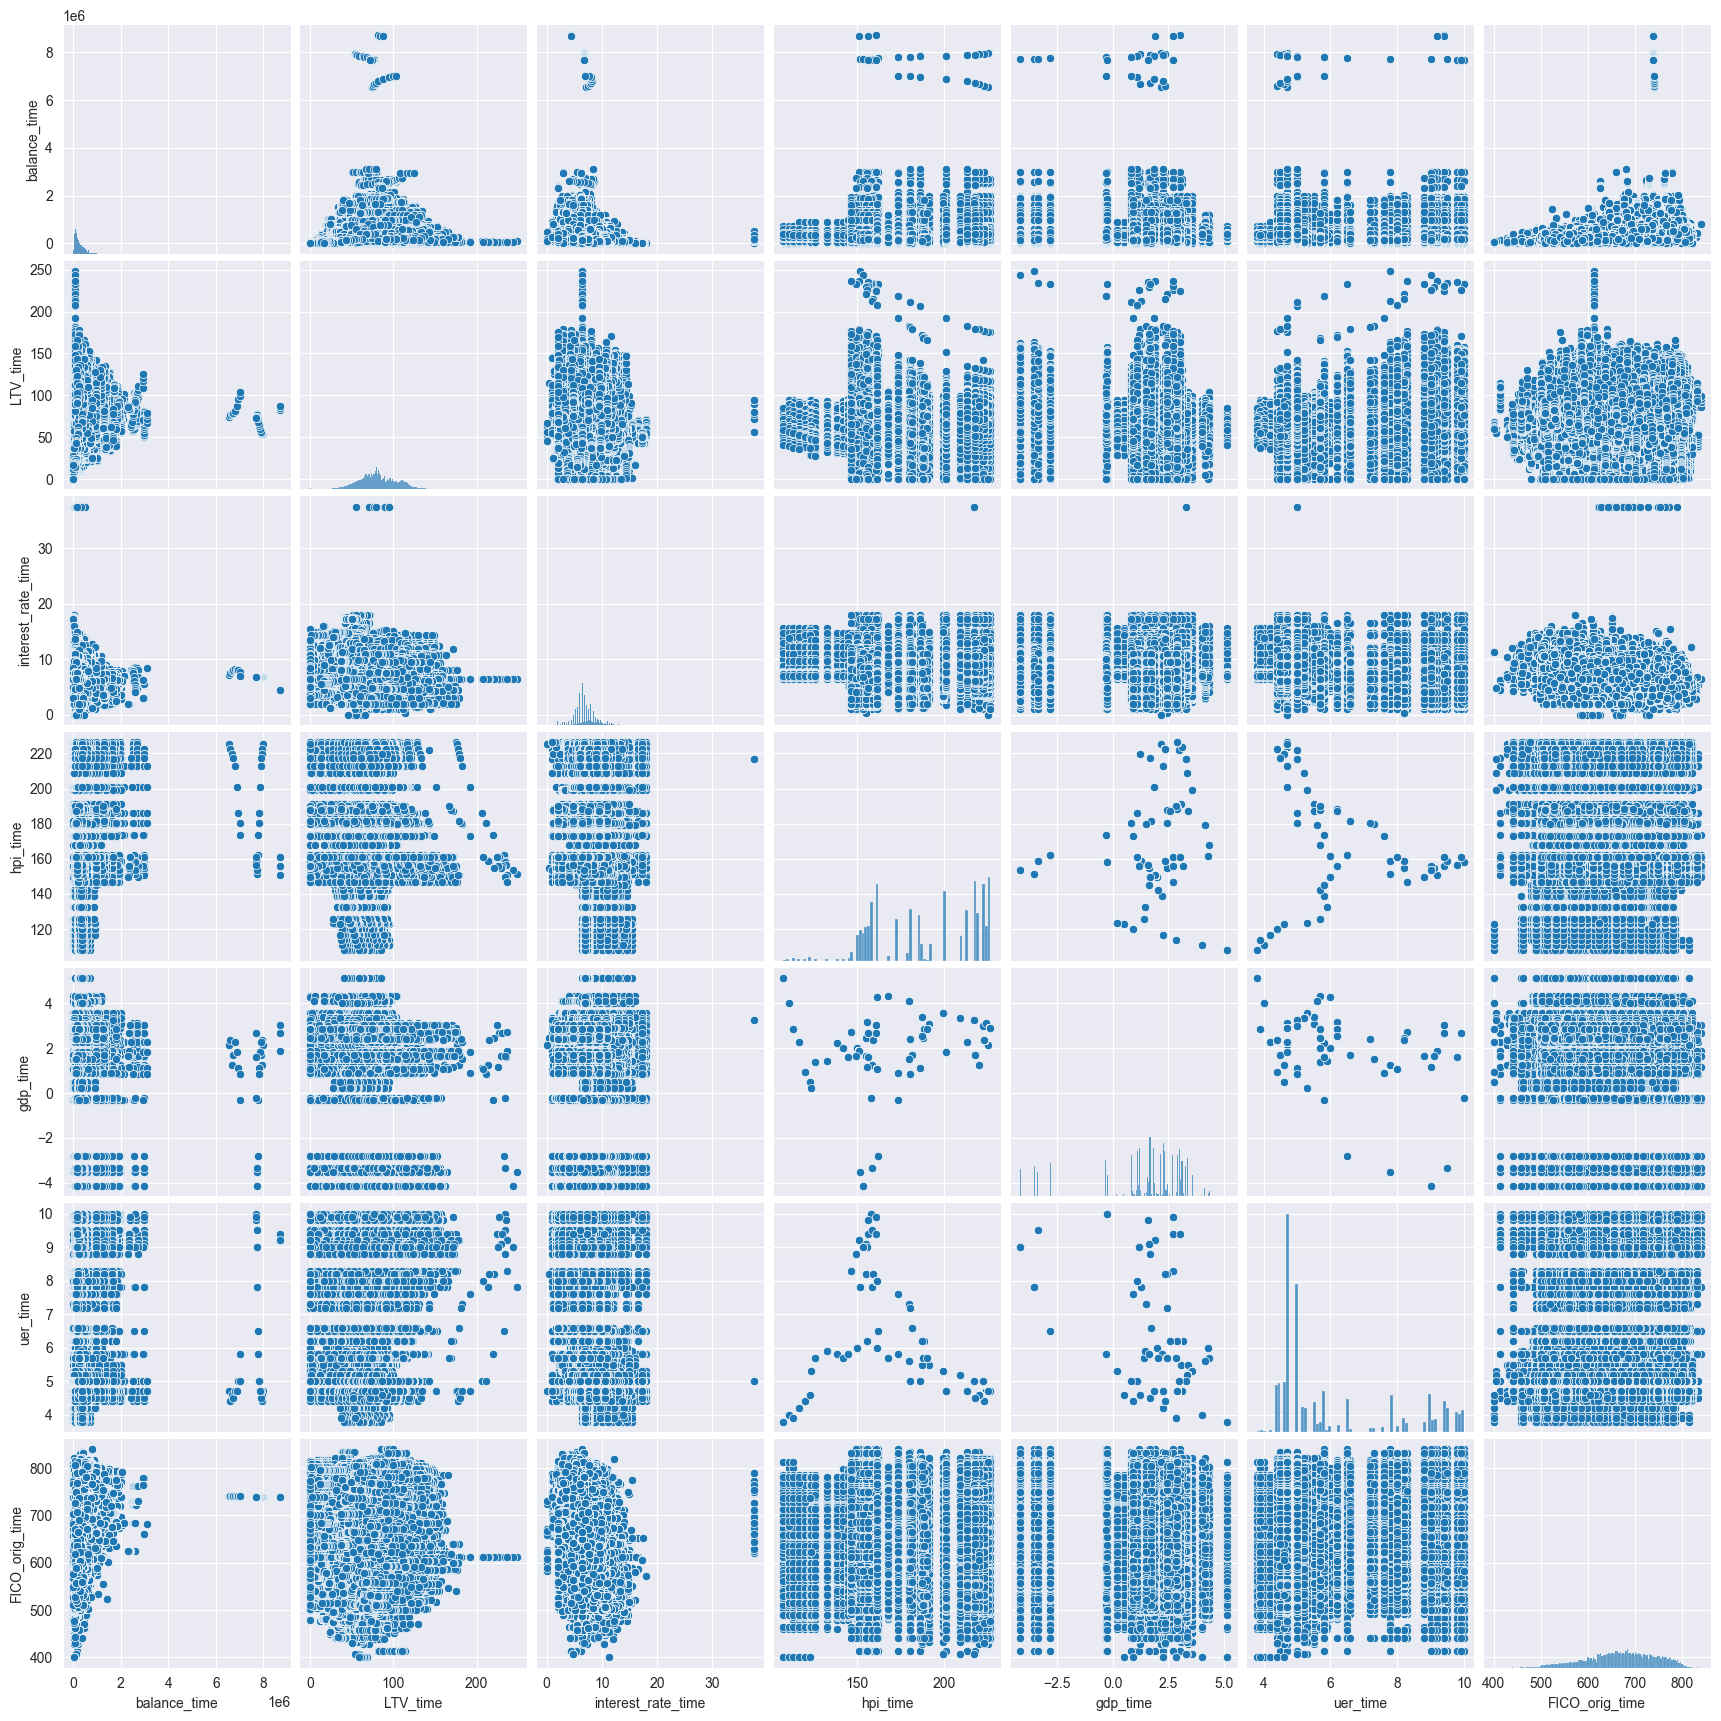

In [14]:
# Pairplot for numeric variables
sns.pairplot(df_dev[['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time']])
plt.show()


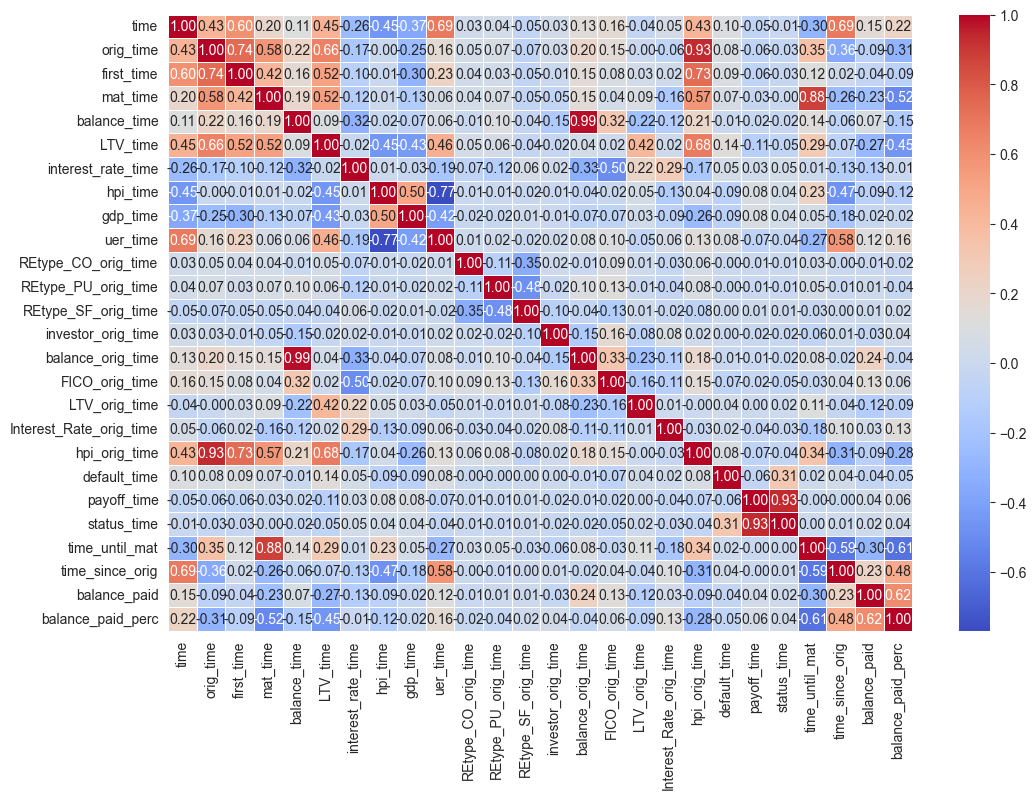

In [15]:
 # Correlation heatmap
correlation_matrix = df_dev.drop(columns=['id']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


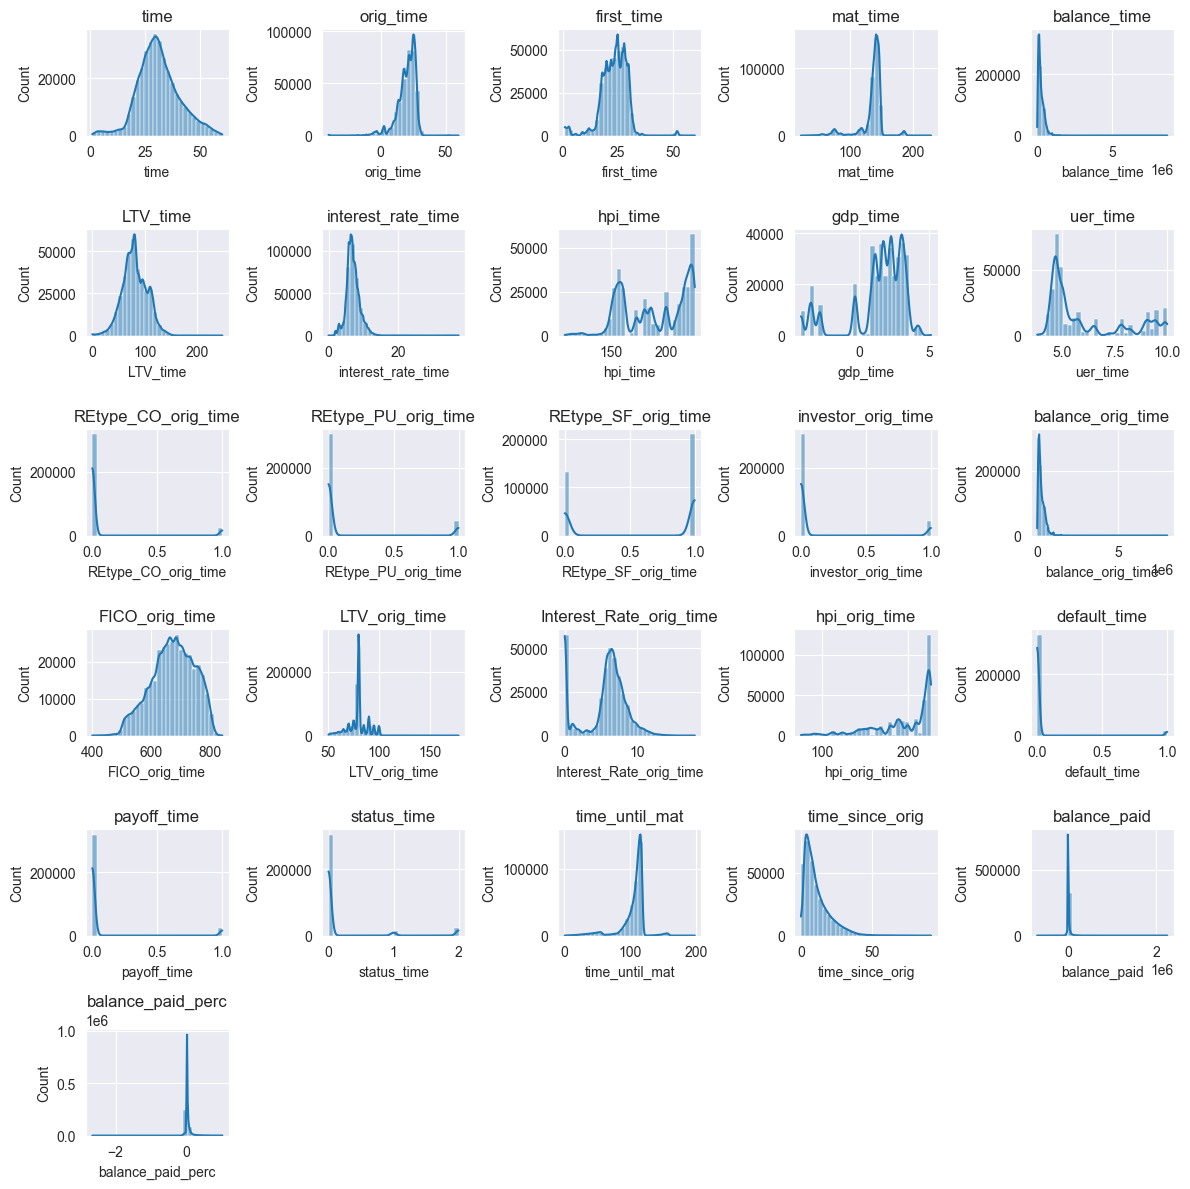

In [16]:
# Plot distributions
plt.figure(figsize=(12, 12))

for i, feature in enumerate(num_vars, 1):
    plt.subplot(6, 5, i)
    sns.histplot(df_dev[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()  # Add this line to prevent subplot overlap
plt.show()

In [17]:
# Group by home type and calculate the mean FICO score within each home type
home_type_fico_mean = df_dev.groupby(['REtype_SF_orig_time'])['FICO_orig_time'].mean()
print(home_type_fico_mean)

REtype_SF_orig_time
0    684.078220
1    664.806784
Name: FICO_orig_time, dtype: float64


In [18]:
# TODO: попробовать разные вариации с типом домов и мб другими переменными (пример выше из docs/mortgage_data_inspection.py)

### Step 1.3: Target construction

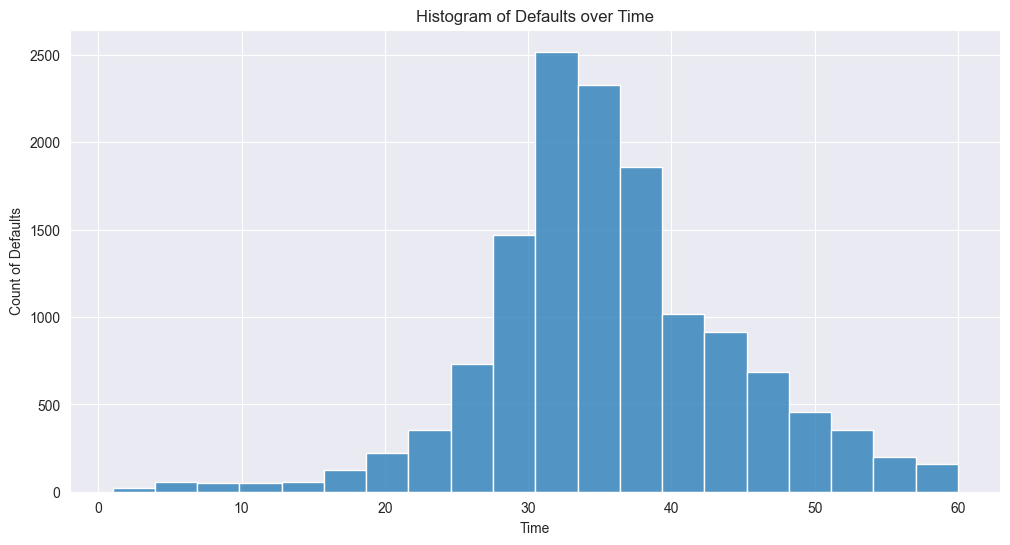

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time'], binwidth=3, kde=False)
plt.title('Histogram of Defaults over Time')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

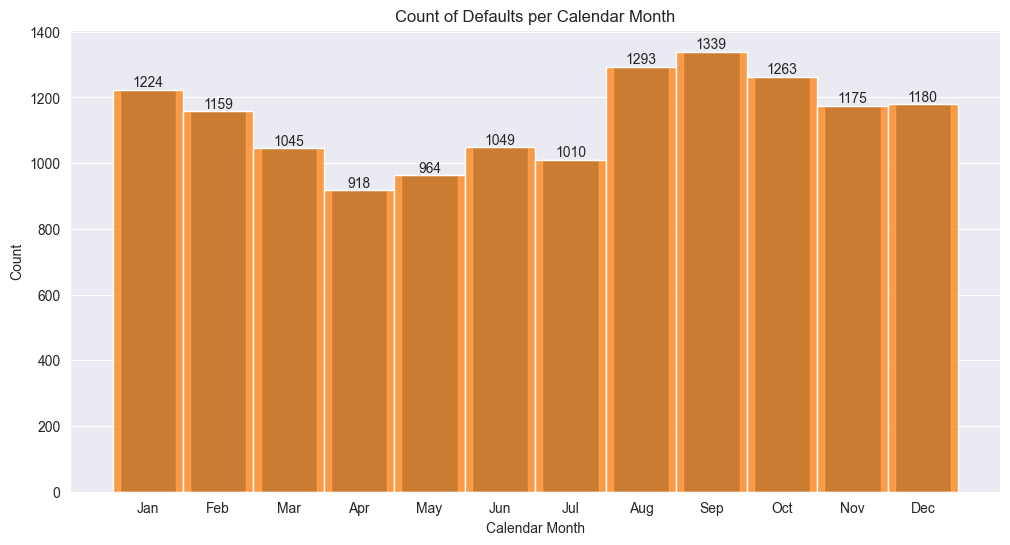

In [20]:
df_dev['calendar_month'] = df_dev['time'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['calendar_month'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['calendar_month'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Calendar Month')
plt.xlabel('Calendar Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')
    
plt.show()

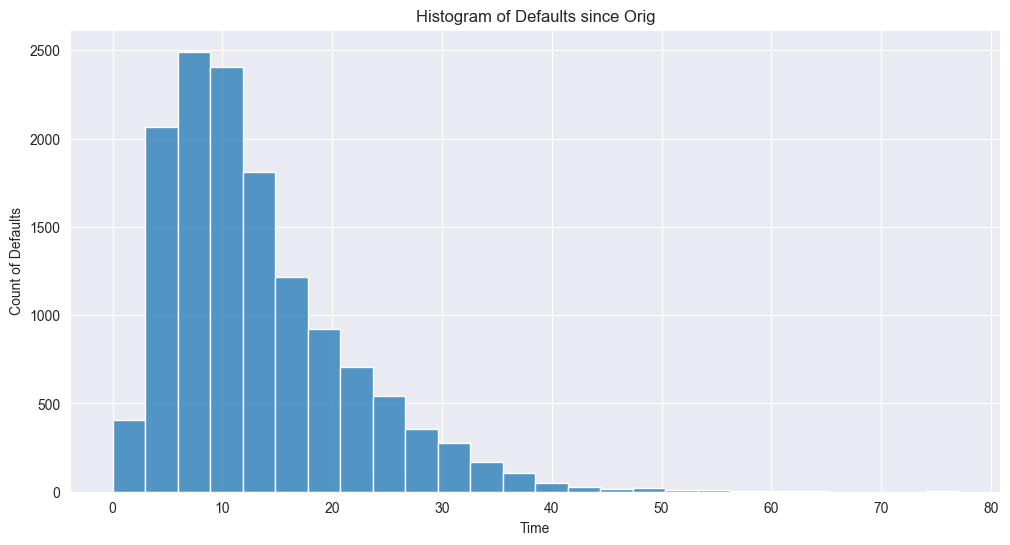

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time_since_orig'], binwidth=3, kde=False)
plt.title('Histogram of Defaults since Orig')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

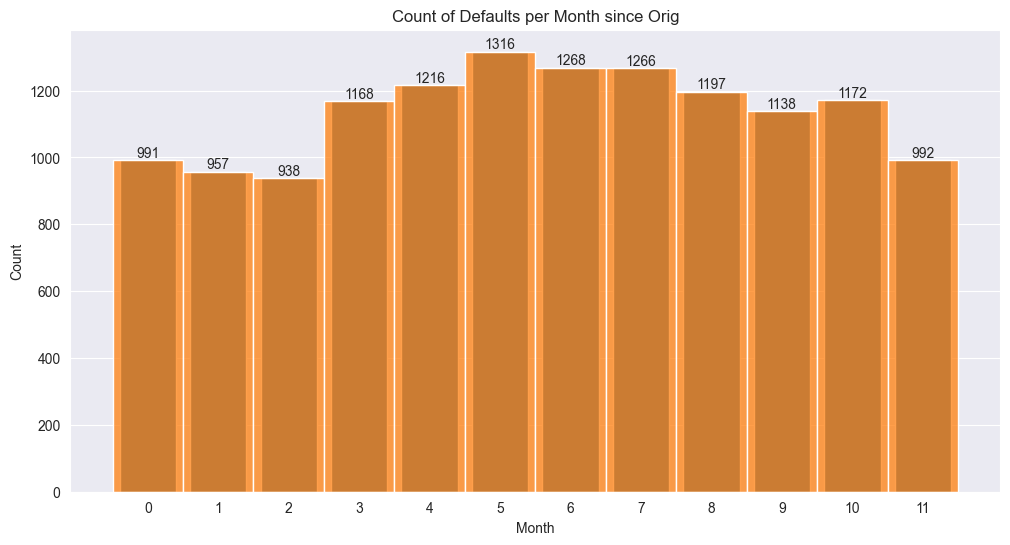

In [22]:
df_dev['month_since_orig'] = df_dev['time_since_orig'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

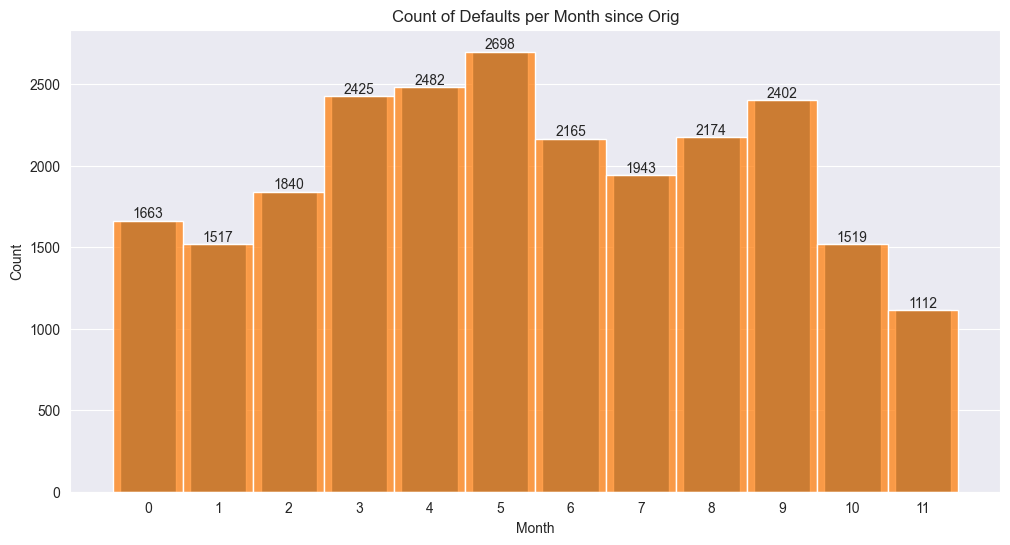

In [23]:
# Filter data where 'default_time' is 1
payoff_df = df_dev[df_dev['payoff_time'] == 1]
count_per_month = payoff_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(payoff_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

Let's choose as a cohort the time since origination. We will check if the client defaulted in the every next 12 months since origination.

#### Building target variable

##### Check initial distribution of defaulted clients

/var/folders/xy/x1w3hm6j7fggl0x6256d8wfr0000gn/T/ipykernel_33057/404253546.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_default_sum, palette='viridis')


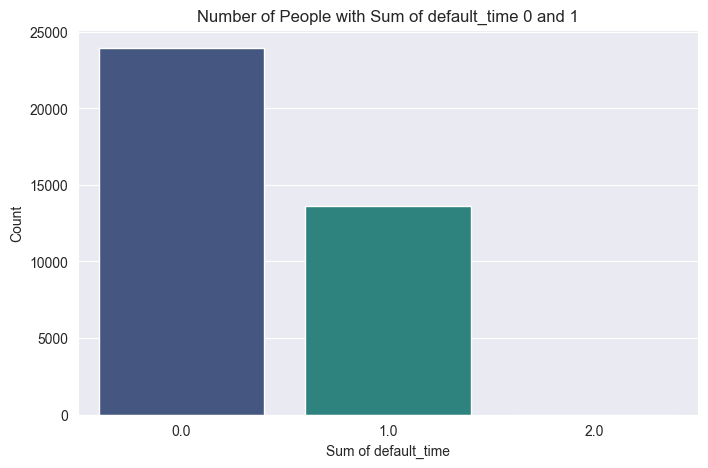

In [24]:
# Group by 'id' and calculate the sum of 'default_time'
df_default_sum = df_dev.groupby('id')['default_time'].sum()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.countplot(x=df_default_sum, palette='viridis')
plt.title('Number of People with Sum of default_time 0 and 1')
plt.xlabel('Sum of default_time')
plt.ylabel('Count')
plt.show()

The distribution of defaulted clients is imbalanced.

Also, we can see that there are clients who defaulted more than once. Let's check how many of them are there, and drop them from the dataset.

In [25]:
# Filter out clients who defaulted more than once
print("Number of clients who defaulted more than once:", len(df_default_sum[df_default_sum > 1]))

Number of clients who defaulted more than once: 4


In [26]:
# Drop clients who defaulted more than once
df_dev = df_dev[~df_dev['id'].isin(df_default_sum[df_default_sum > 1].index)]

##### Target logic

If the client defaults (default_time == 1) within 12-months-window since origination, then we will mark the cohort as 1, otherwise 0.

In [27]:
df_dev['target'] = 0

In [28]:
def mark_defaults(df):
    # Create a copy of the DataFrame
    df_copy = df.copy()

    # Group by id and take the last observation per id
    last_observation = df.groupby('id').last()

    # Mark rows where the last observation has 'default_time' equal to 1
    defaulted_ids = last_observation[last_observation['default_time'] == 1].index

    # Iterate over defaulted_ids and update 'target' column accordingly
    for defaulted_id in defaulted_ids:
        # Filter rows for the current defaulted_id
        df_id = df_copy[df_copy['id'] == defaulted_id]

        # Find the value of 'month_since_orig' for the last observation
        last_month_since_orig = df_id['month_since_orig'].tail(1).values[0]

        # Set the 'target' column to 1 in the last n+1 rows
        df_copy.loc[df_id.index[-(last_month_since_orig+1):], 'target'] = 1

    return df_copy


In [29]:
df_dev = mark_defaults(df_dev)

### Step 1.4: Setting Cohort

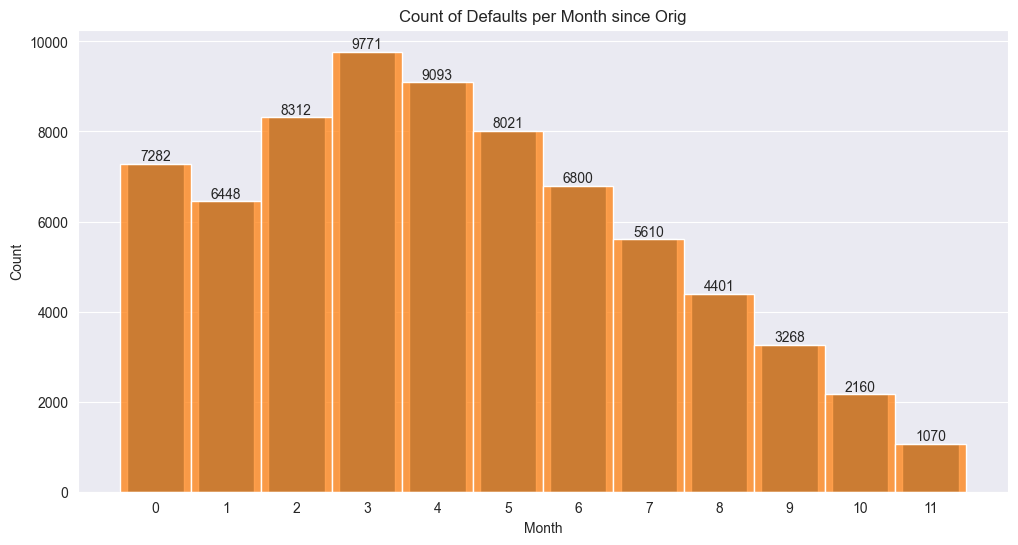

In [30]:
# Filter data where 'target' is 1
default_df = df_dev[df_dev['target'] == 1]
count_per_month = default_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

Let's choose a flexible cohort – every 4th month since origination

In [31]:
df_dev = df_dev[df_dev['month_since_orig'] == 3]

# Drop columns that we don't need anymore
df_dev.drop(columns=['id', 'time', 'orig_time', 'first_time', 'mat_time', 'default_time', 'payoff_time', 'status_time', 'calendar_month', 'month_since_orig'], inplace=True)

Distribution of target:
target
0    28944
1     9771
Name: count, dtype: int64


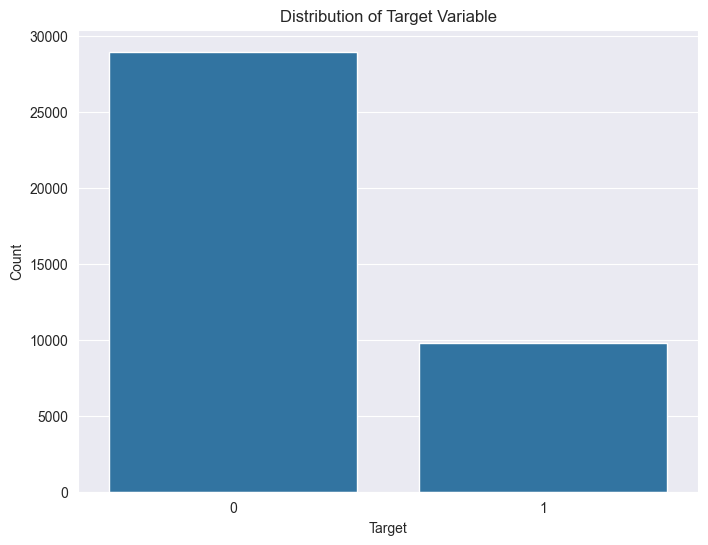

In [32]:
print("Distribution of target:", df_dev['target'].value_counts(), sep='\n')

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_dev)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The target distribution is imbalanced. Most of the clients didn't default.

### Step 1.5: Outlier Treatment

In [33]:
pd.options.display.float_format = '{:.3f}'.format
df_dev.drop(columns=['target']).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

balance_time  LTV_time  interest_rate_time  hpi_time  gdp_time  \
count     38715.000 38715.000           38715.000 38715.000 38715.000   
mean     259763.402    79.554               7.132   196.629     1.929   
std      215607.784    19.539               1.755    28.429     1.682   
min           0.000     0.000               1.000   107.830    -4.147   
5%        53759.580    47.637               4.625   150.910    -2.806   
25%      116728.375    69.873               6.000   167.910     1.586   
50%      200000.000    78.866               6.990   208.860     2.274   
75%      352849.840    88.482               8.104   219.670     3.029   
95%      622053.014   113.085              10.250   226.290     3.556   
max     7899963.800   233.575              18.000   226.290     5.132   

       uer_time  REtype_CO_orig_time  REtype_PU_orig_time  \
count 38715.000            38715.000            38715.000   
mean      5.774                0.068                0.128   
std       1.768                0.253                0.334   
min       3.800                0.000                0.000   
5%        4.400                0.000                0.000   
25%       4.700                0.000                0.000   
50%       5.000                0.000                0.000   
75%       5.800                0.000                0.000   
95%       9.800                1.000                1.000   
max      10.000                1.000                1.000   

       REtype_SF_orig_time  investor_orig_time  balance_orig_time  \
count            38715.000           38715.000          38715.000   
mean                 0.618               0.127         265803.688   
std                  0.486               0.333         220458.006   
min                  0.000               0.000           9575.000   
5%                   0.000               0.000          56900.000   
25%                  0.000               0.000         120000.000   
50%                  1.000               0.000         203520.000   
75%                  1.000               0.000         360000.000   
95%                  1.000               1.000         636000.000   
max                  1.000               1.000        8000000.000   

       FICO_orig_time  LTV_orig_time  Interest_Rate_orig_time  hpi_orig_time  \
count       38715.000      38715.000                38715.000      38715.000   
mean          668.731         79.403                    5.506        198.751   
std            71.175          9.795                    3.192         32.467   
min           400.000         50.100                    0.000         75.910   
5%            542.000         60.200                    0.000        132.760   
25%           621.000         75.000                    4.375        186.910   
50%           671.000         80.000                    6.375        216.770   
75%           723.000         81.000                    7.500        222.390   
95%           780.000         95.000                    9.750        226.290   
max           840.000        178.600                   18.000        226.290   

       time_until_mat  time_since_orig  balance_paid  balance_paid_perc  
count       38715.000        38715.000     38715.000          38715.000  
mean          109.193            8.205      6040.286              0.025  
std            18.386            8.902     33654.373              0.084  
min             1.000            3.000   -245697.840             -0.763  
5%             65.000            3.000     -2742.820             -0.010  
25%           105.000            3.000         0.050              0.000  
50%           117.000            3.000       537.680              0.004  
75%           117.000           15.000      2538.250              0.014  
95%           118.000           27.000     28860.886              0.125  
max           198.000           87.000   2000000.000              1.000

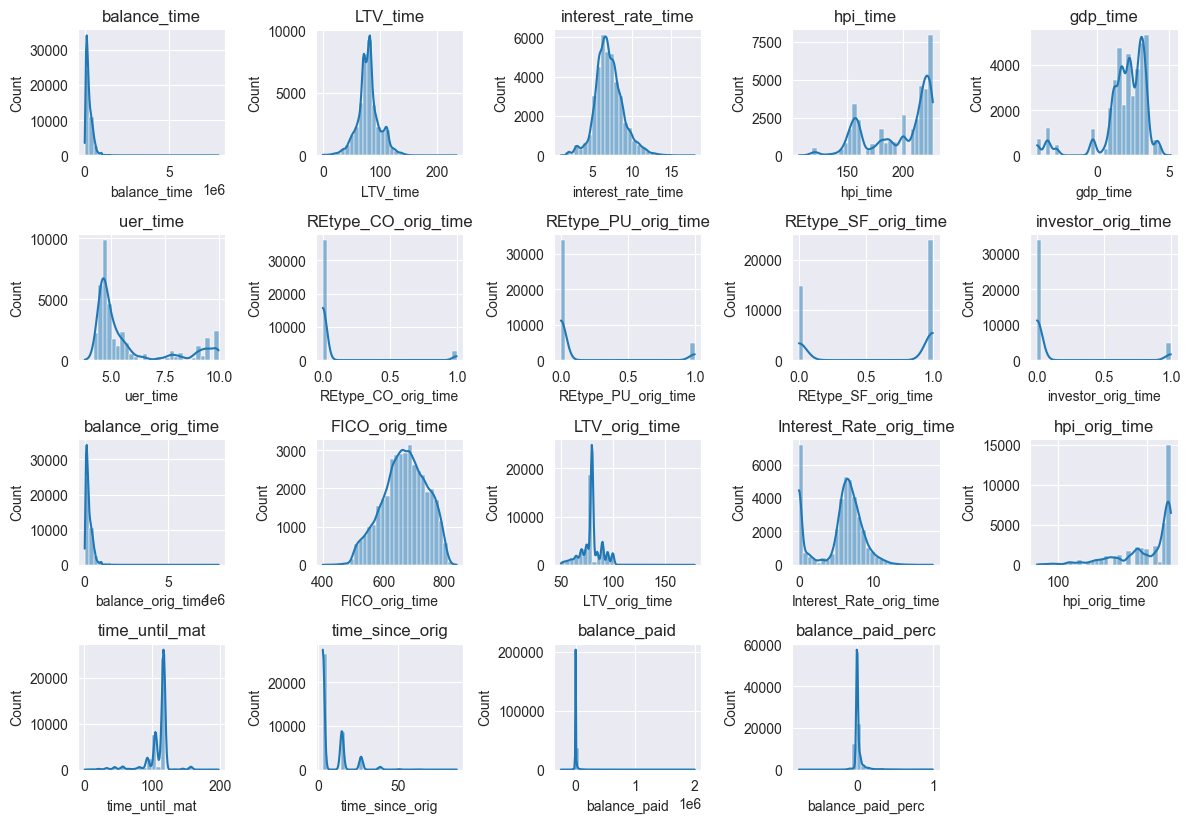

In [34]:
num_vars = df_dev.select_dtypes(include=['float64', 'int64']).drop(columns=['target']).columns

plt.figure(figsize=(12, 12))
for i, feature in enumerate(num_vars, 1):
    plt.subplot(6, 5, i)
    sns.histplot(df_dev[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

Convert outliers into 5th and 95th quantiles values

In [35]:
# According to the distribution plots, the following columns have outliers:
treat_columns = [
    "balance_time", "LTV_time", "interest_rate_time",
    "hpi_time", "gdp_time", "balance_orig_time",
    "FICO_orig_time", "LTV_orig_time", "Interest_Rate_orig_time",
    "hpi_orig_time", "time_until_mat" ,"time_since_orig",
    "balance_paid", "balance_paid_perc"
]

def outlier_treatment(df):
    df_copy = df[treat_columns].copy()

    # Iterate over the columns in df
    for col in df_copy.columns:
        # Calculate 5th and 95th percentiles
        q_05, q_95 = df_copy[col].quantile([0.05, 0.95])

        # Replace the outliers
        df_copy[col] = df_copy[col].clip(q_05, q_95, axis=0)

    return df_copy

In [36]:
df_dev[treat_columns] = outlier_treatment(df_dev)

In [37]:
# По порядку:
# TODO: Binning
# TODO: Correlation Analysis
# TODO: Feature Selection
# TODO: Model training
# TODO: Scorecard building
# TODO: Scorecard validation

## Step 2: Binning process

The first step is to set breakpoints for individual bins

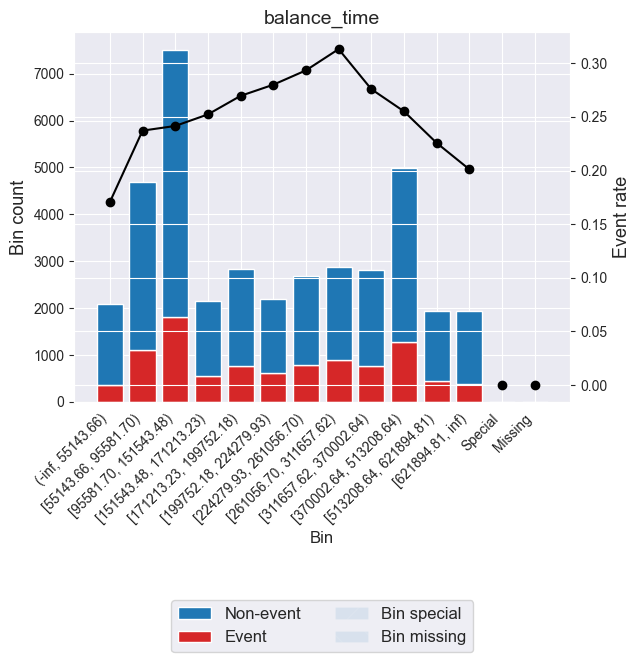

In [38]:
predictor = 'balance_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)


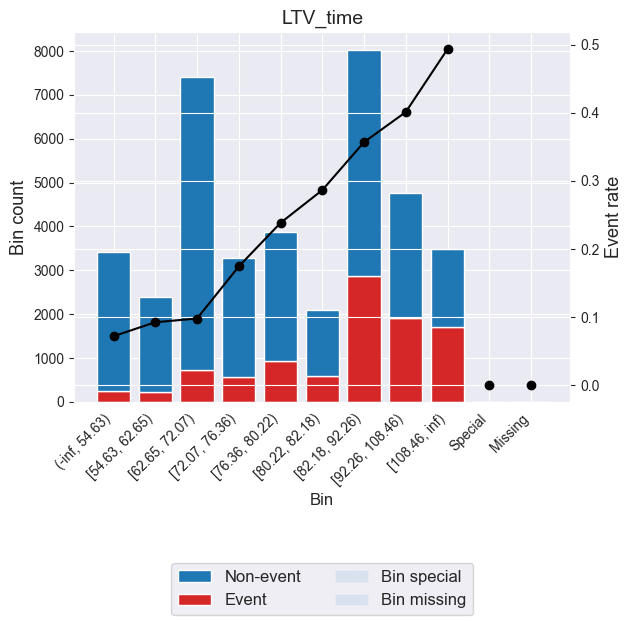

In [39]:
predictor = 'LTV_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

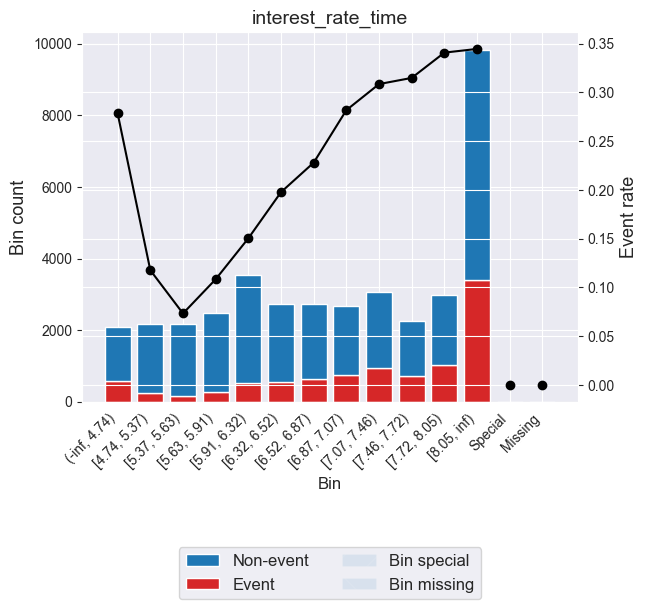

In [40]:
predictor = 'interest_rate_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

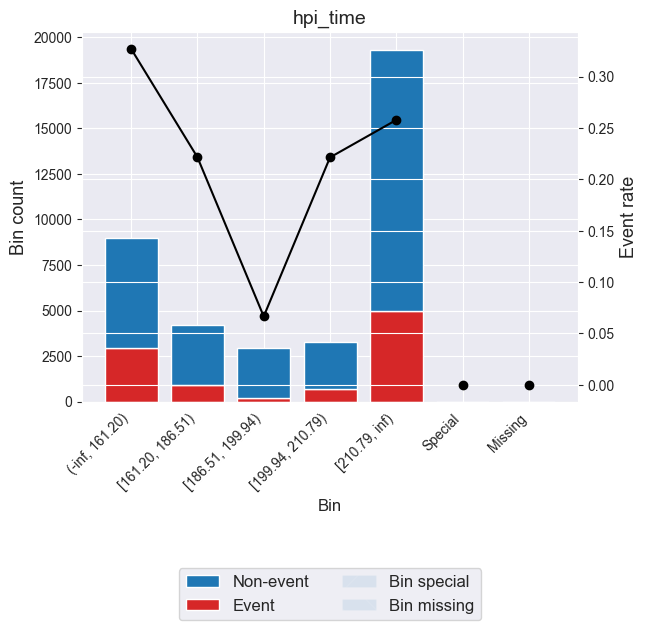

In [41]:
predictor = 'hpi_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

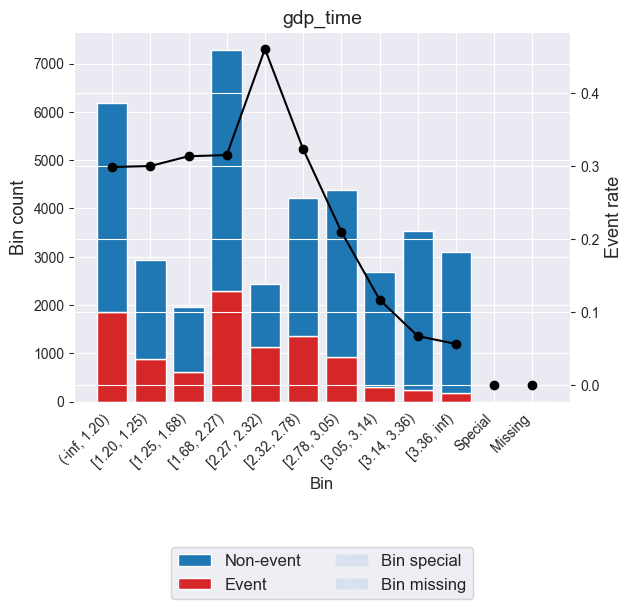

In [42]:
predictor = 'gdp_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

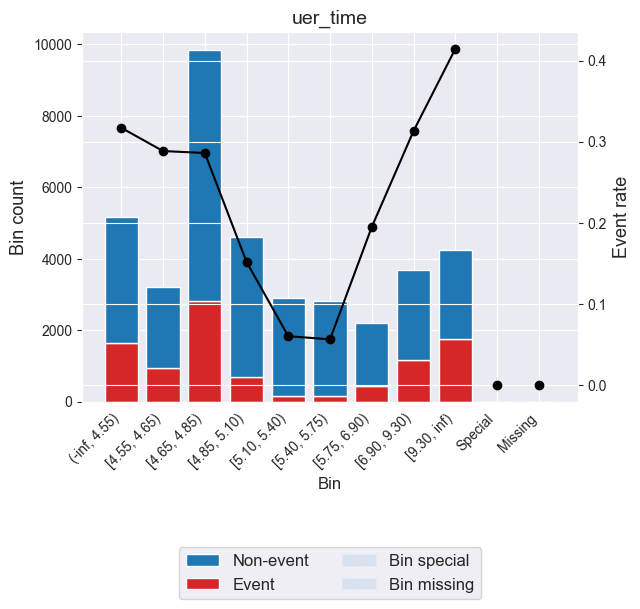

In [43]:
predictor = 'uer_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

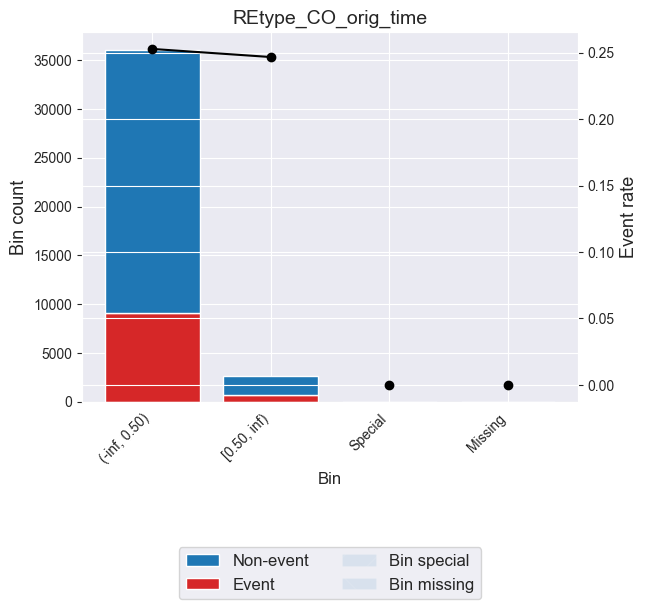

In [44]:
predictor = 'REtype_CO_orig_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

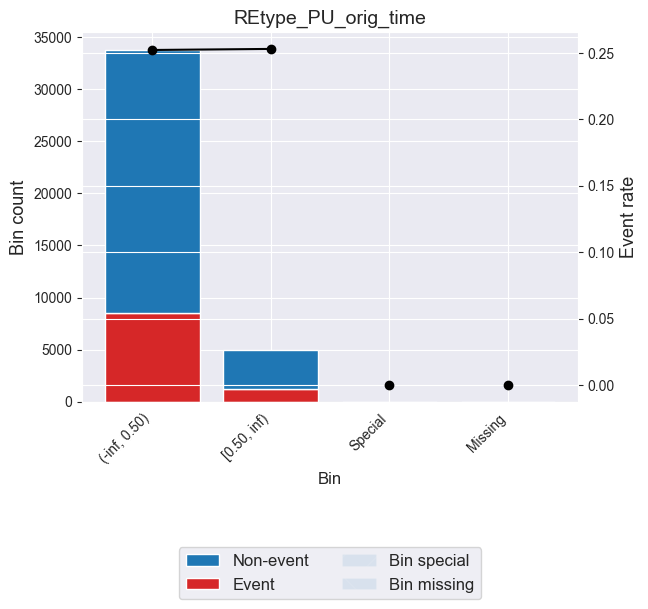

In [45]:
predictor = 'REtype_PU_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

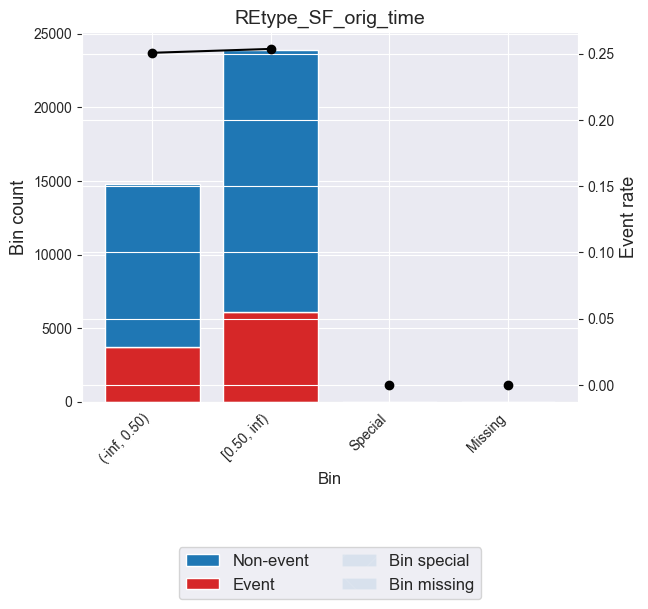

In [46]:
predictor = 'REtype_SF_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

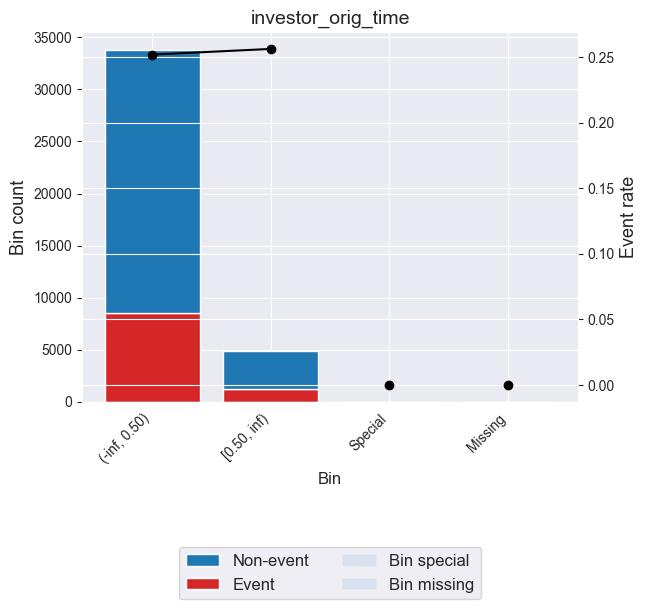

In [47]:
predictor = 'investor_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

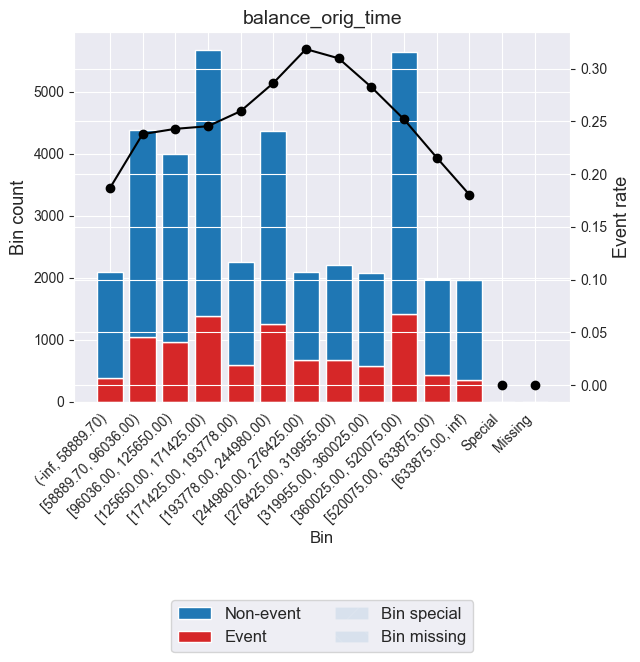

In [48]:
predictor = 'balance_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

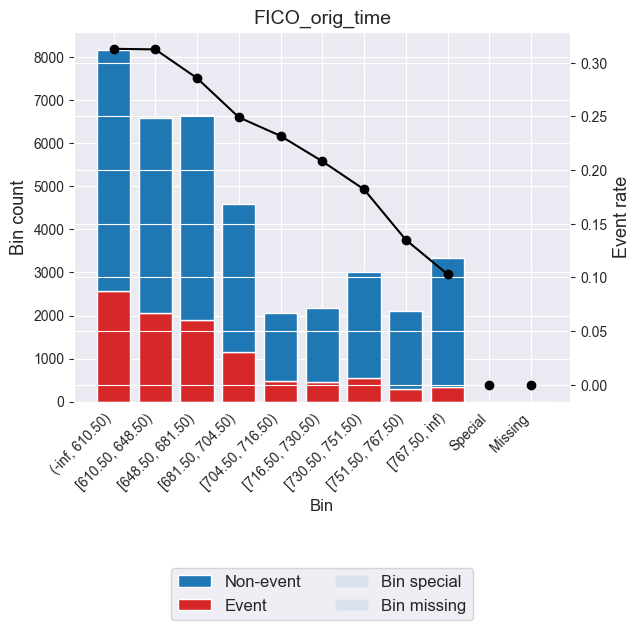

In [49]:
predictor = 'FICO_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

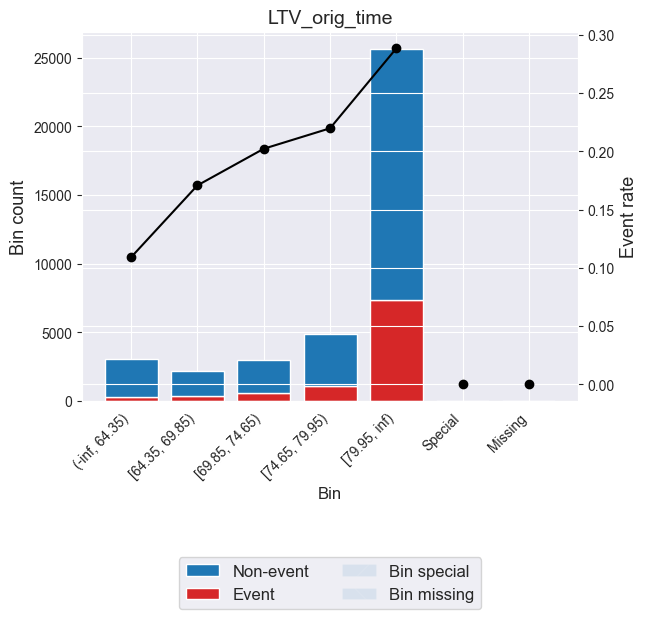

In [50]:
predictor = 'LTV_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

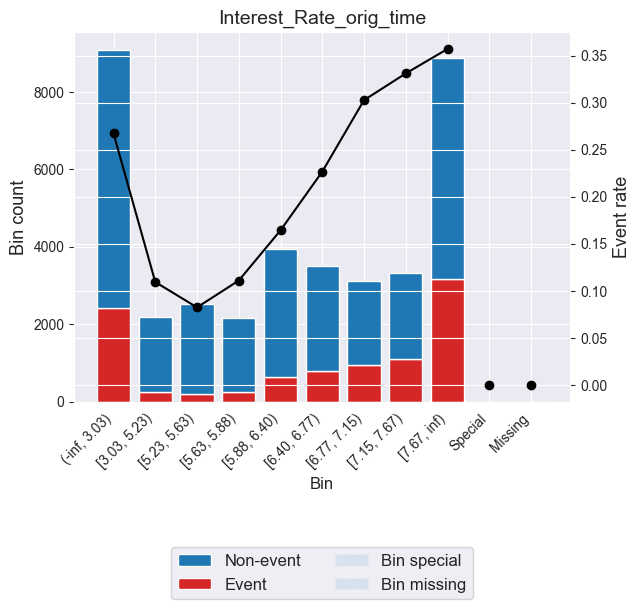

In [51]:
predictor = 'Interest_Rate_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

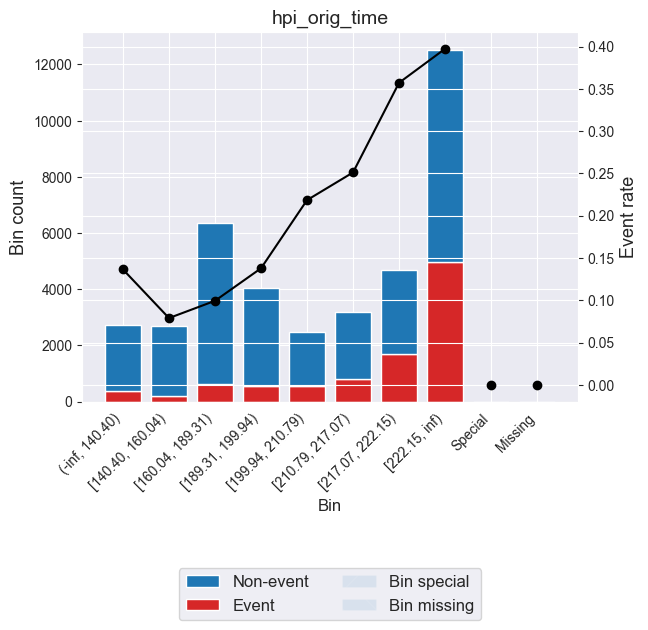

In [52]:
predictor = 'hpi_orig_time'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

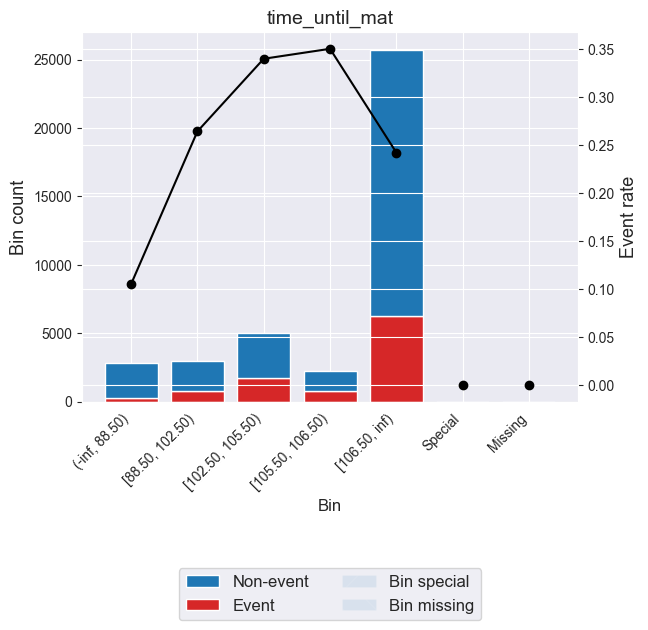

In [53]:
predictor = 'time_until_mat'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

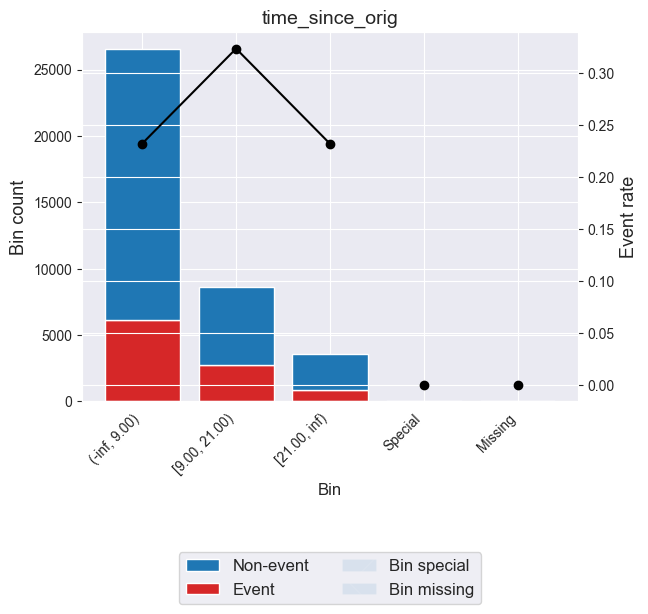

In [54]:
predictor = 'time_since_orig'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

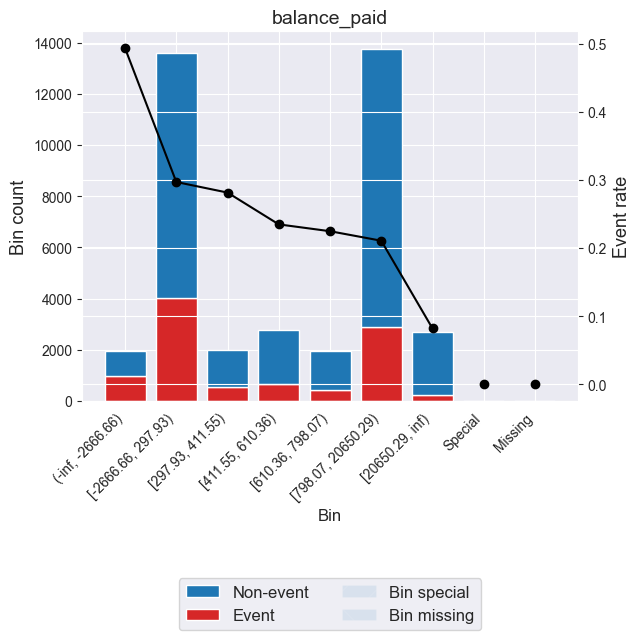

In [55]:
predictor = 'balance_paid'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

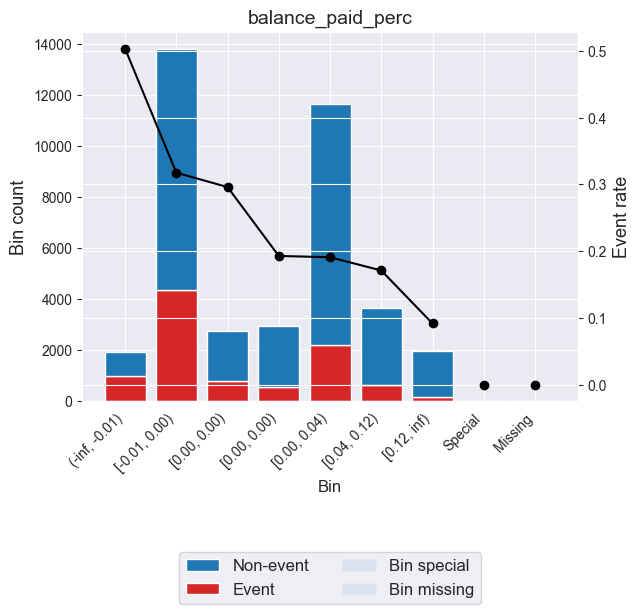

In [56]:
predictor = 'balance_paid_perc'
x = df_dev[predictor]
y = df_dev['target']

optb = OptimalBinning(name=predictor)
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

Generate new bins by reshaping the existing bins to establish a linearized correlation:

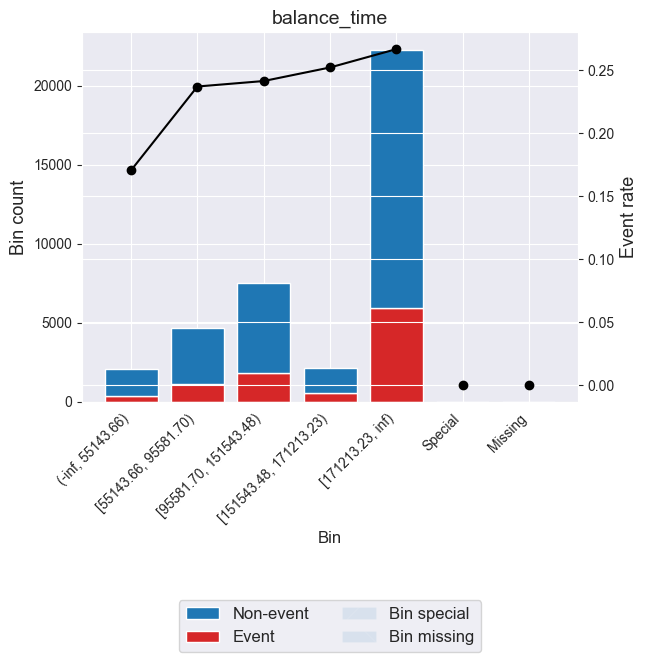

In [57]:
predictor = 'balance_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)


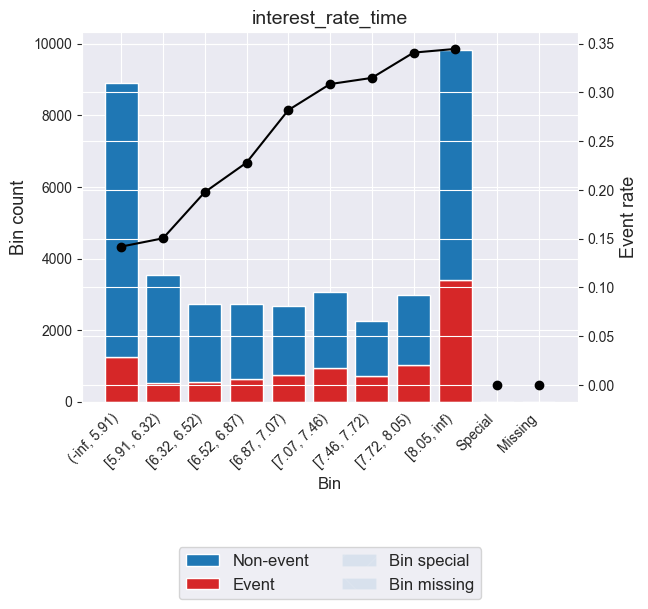

In [58]:
predictor = 'interest_rate_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

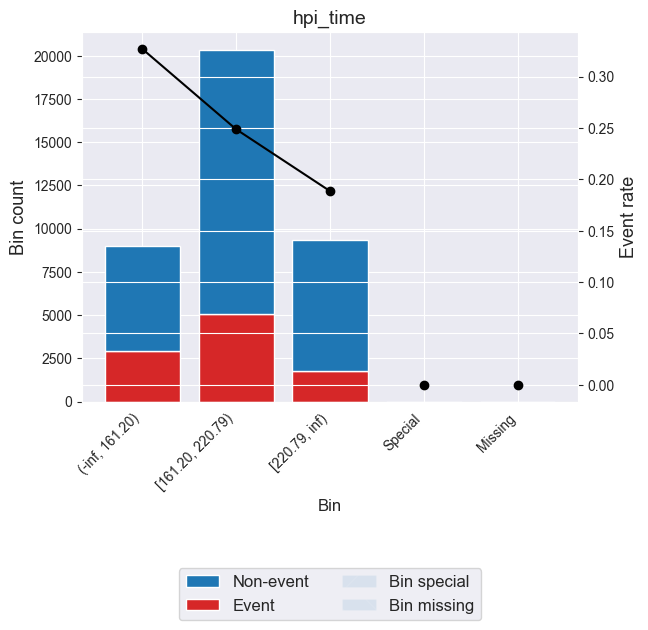

In [59]:
predictor = 'hpi_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

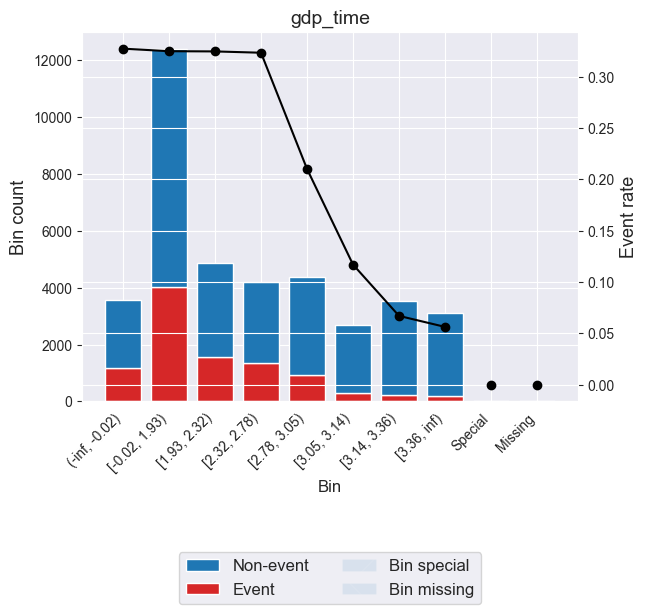

In [60]:
predictor = 'gdp_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

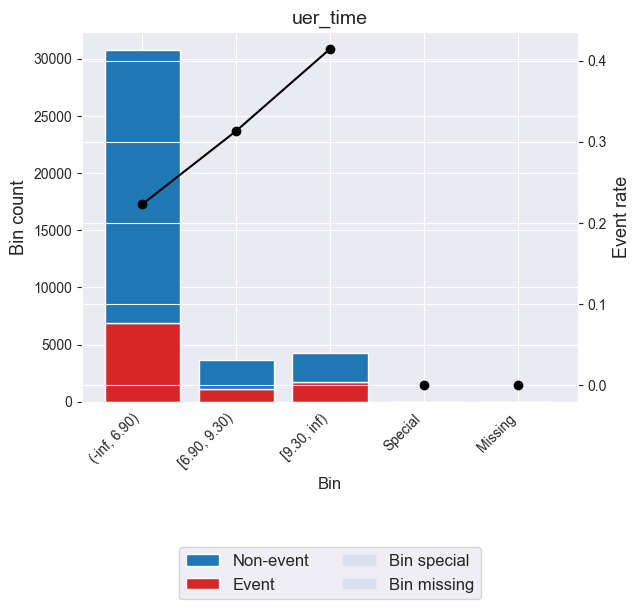

In [61]:
predictor = 'uer_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

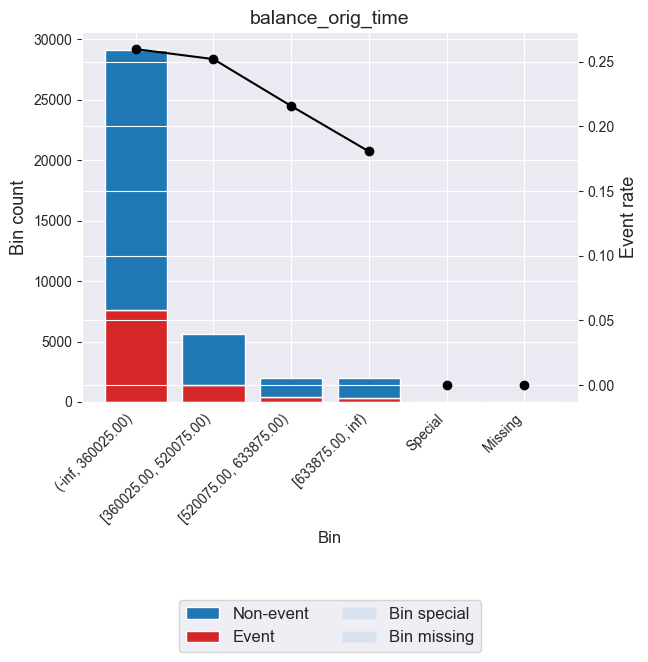

In [62]:
predictor = 'balance_orig_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

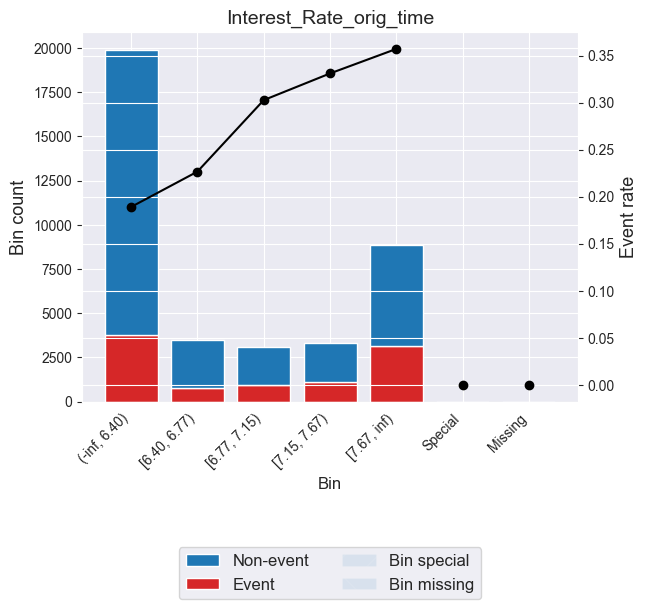

In [63]:
predictor = 'Interest_Rate_orig_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

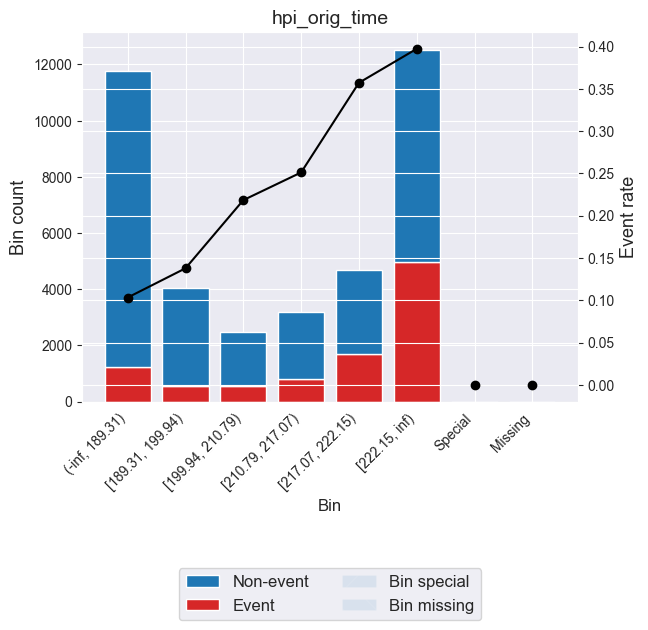

In [64]:
predictor = 'hpi_orig_time'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

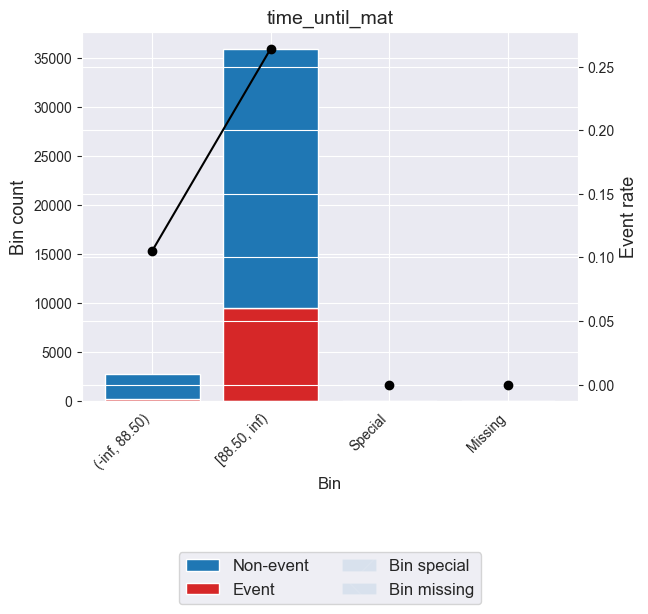

In [65]:
predictor = 'time_until_mat'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

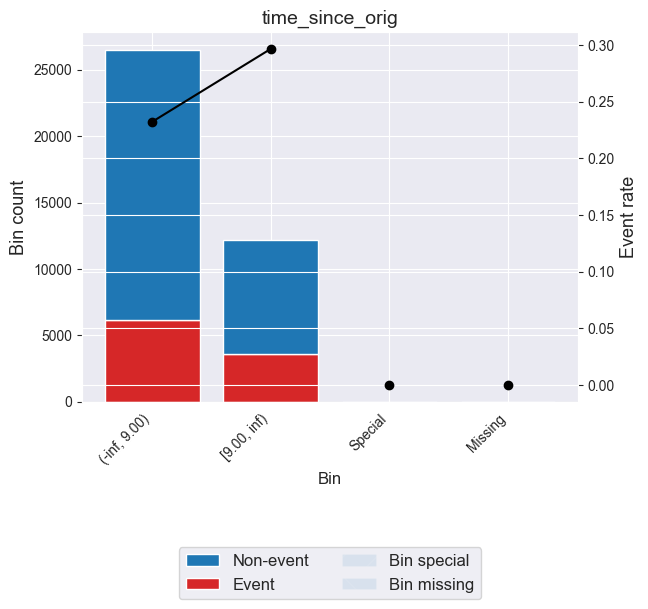

In [66]:
predictor = 'time_since_orig'
x=df_dev[predictor]
y=df_dev['target']

optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc")
optb.fit(x, y)
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

## Step 3: Univariate analysis

Total results for all predictors. The predictors selected for the model must have a Gini coefficient greater than 0.2 (20%). Therefore, let's add this criterion to the function.

In [67]:
predictors = ['balance_time','LTV_time','interest_rate_time','hpi_time','gdp_time','uer_time','REtype_CO_orig_time','REtype_PU_orig_time','REtype_SF_orig_time','investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time','Interest_Rate_orig_time','hpi_orig_time','time_until_mat','time_since_orig','balance_paid','balance_paid_perc']
binning_process = BinningProcess(variable_names = predictors,min_bin_size=0.05, selection_criteria = {"gini": {"min": 0.2, "max": 1}})
x=df_dev.drop('target', axis =1)
y=df_dev['target']

binning_process.fit_transform(x, y)
binning_process.summary()

name      dtype   status  selected n_bins    iv    js  \
0              balance_time  numerical  OPTIMAL     False     12 0.031 0.004   
1                  LTV_time  numerical  OPTIMAL      True      9 0.630 0.075   
2        interest_rate_time  numerical  OPTIMAL      True     12 0.289 0.035   
3                  hpi_time  numerical  OPTIMAL     False      5 0.156 0.018   
4                  gdp_time  numerical  OPTIMAL      True     10 0.453 0.053   
5                  uer_time  numerical  OPTIMAL      True      9 0.408 0.047   
6       REtype_CO_orig_time  numerical  OPTIMAL     False      2 0.000 0.000   
7       REtype_PU_orig_time  numerical  OPTIMAL     False      2 0.000 0.000   
8       REtype_SF_orig_time  numerical  OPTIMAL     False      2 0.000 0.000   
9        investor_orig_time  numerical  OPTIMAL     False      2 0.000 0.000   
10        balance_orig_time  numerical  OPTIMAL     False     12 0.035 0.004   
11           FICO_orig_time  numerical  OPTIMAL     False      9 0.157 0.019   
12            LTV_orig_time  numerical  OPTIMAL     False      5 0.105 0.013   
13  Interest_Rate_orig_time  numerical  OPTIMAL      True      9 0.274 0.033   
14            hpi_orig_time  numerical  OPTIMAL      True      8 0.519 0.063   
15           time_until_mat  numerical  OPTIMAL     False      5 0.102 0.012   
16          time_since_orig  numerical  OPTIMAL     False      3 0.038 0.005   
17             balance_paid  numerical  OPTIMAL      True      7 0.192 0.023   
18        balance_paid_perc  numerical  OPTIMAL      True      7 0.233 0.028   

    gini quality_score  
0  0.094         0.010  
1  0.421         0.397  
2  0.272         0.091  
3  0.161         0.471  
4  0.310         0.007  
5  0.300         0.090  
6  0.002         0.000  
7  0.000         0.000  
8  0.004         0.000  
9  0.003         0.000  
10 0.100         0.004  
11 0.194         0.026  
12 0.140         0.244  
13 0.269         0.819  
14 0.376         0.830  
15 0.136         0.153  
16 0.084         0.094  
17 0.207         0.241  
18 0.247         0.126

## Step 4: Correlation analysis

Perform a correlation analysis using the Spearman coefficient between the predictors and find pairs between them that have a high coefficient

In [68]:
x=pd.DataFrame(df_dev.drop('target', axis =1))
correlation_results = []
variable_combinations = combinations(x.columns, 2)

for var1, var2 in variable_combinations:
    coef, p_value = spearmanr(x[var1], x[var2])
    if abs(coef) > 0.4:
        significance = 'Significant' if p_value < 0.05 else 'Not Significant'
        correlation_results.append({
            'Variable Pair': f'{var1} - {var2}',
            'Spearman Coefficient': coef,
            'p-value': p_value,
            'Significance': significance
        })

correlation_results_df = pd.DataFrame(correlation_results)

print(correlation_results_df)

                                   Variable Pair  Spearman Coefficient  \
0               balance_time - balance_orig_time                 0.992   
1                       LTV_time - LTV_orig_time                 0.503   
2                       LTV_time - hpi_orig_time                 0.547   
3         interest_rate_time - balance_orig_time                -0.404   
4            interest_rate_time - FICO_orig_time                -0.525   
5   interest_rate_time - Interest_Rate_orig_time                 0.467   
6                            hpi_time - uer_time                -0.758   
7                      hpi_time - time_until_mat                 0.452   
8                     hpi_time - time_since_orig                -0.564   
9                      uer_time - time_until_mat                -0.431   
10                    uer_time - time_since_orig                 0.599   
11     REtype_PU_orig_time - REtype_SF_orig_time                -0.486   
12              time_until_mat - time_

Based on the Gini coefficient, pairwise correlation coefficient and linearity, the following variables were selected for the model: 

In [69]:
selected_columns = ['balance_orig_time', 'LTV_time','interest_rate_time', 'gdp_time', 'uer_time','hpi_orig_time', 'balance_paid_perc']
selected_columns

['balance_orig_time',
 'LTV_time',
 'interest_rate_time',
 'gdp_time',
 'uer_time',
 'hpi_orig_time',
 'balance_paid_perc']

The exception is the 'balance_orig_time' variable, which does not pass the Gini coefficient condition. The reason for choosing this variable is that this variable depends on the actions of the individual, and is not a macroeconomic indicator. This action will help to make the model more realistic

In [70]:
selected_columns = ['balance_orig_time', 'LTV_time','interest_rate_time', 'gdp_time', 'uer_time','hpi_orig_time', 'balance_paid_perc']
df_selected_variables = df_dev[selected_columns]
df_selected_variables

balance_orig_time  LTV_time  interest_rate_time  gdp_time  uer_time  \
7               56900.000    47.637               9.200     1.104     5.000   
19              56900.000    47.637               9.200     1.876     9.200   
78             212000.000    85.459               9.625    -0.314     5.800   
90             212000.000    91.605               6.580     1.176     9.000   
111            128000.000    84.826               8.000     0.837     5.000   
...                   ...       ...                 ...       ...       ...   
622215         242000.000    94.358               7.000     1.081     8.000   
622234          86600.000   101.200               7.500     1.081     8.000   
622246         196000.000   103.307               7.500     1.081     8.000   
622342         232000.000    57.587               6.500     0.893     7.600   
622346         150000.000    49.398               6.400     1.081     8.000   

        hpi_orig_time  balance_paid_perc  
7             132.760              0.125  
19            132.760              0.125  
78            191.420              0.033  
90            191.420              0.069  
111           186.910             -0.010  
...               ...                ...  
622215        226.290              0.000  
622234        226.290              0.099  
622246        226.290              0.078  
622342        155.770              0.125  
622346        149.700              0.125  

[38715 rows x 7 columns]